<a href="https://colab.research.google.com/github/ranjithsrajan/PyLab/blob/main/M2_AST_05_SVM_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Data Science and Machine Intelligence
## A program by IITM and TalentSprint
### Assignment 05: Hard and Soft Margin and Kernel Support Vector Machines

## Learning Objectives

At the end of the experiment, you will be able to

* understand the basics of soft margin vs hard margin SVM
* code a soft margin SVM.
* code a hard margin SVM.
* solve a problem using kernel ridge regression.

### Setup Steps:

In [33]:
#@title Please enter your registration id to start: { run: "auto", display-mode: "form" }
Id = "" #@param {type:"string"}

In [34]:
#@title Please enter your password (your registered phone number) to continue: { run: "auto", display-mode: "form" }
password = "" #@param {type:"string"}

In [3]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython

ipython = get_ipython()

notebook= "M2_AST_05_SVM_A" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")
    from IPython.display import HTML, display
    ipython.magic("sx wget https://cdn.talentsprint.com/aiml/Experiment_related_data/Iris.csv")
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    ipython.magic("notebook -e "+ notebook + ".ipynb")

    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:
        print(r["err"])
        return None
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getAnswer() and getComplexity() and getAdditional() and getConcepts() and getComments() and getMentorSupport():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional,
              "concepts" : Concepts, "record_id" : submission_id,
              "answer" : Answer, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook,
              "feedback_experiments_input" : Comments,
              "feedback_mentor_support": Mentor_support}
      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:
        print(r["err"])
        return None
      else:
        print("Your submission is successful.")
        print("Ref Id:", submission_id)
        print("Date of submission: ", r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://learn-iitm.talentsprint.com/notebook_submissions")
        #print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
        return submission_id
    else: submission_id


def getAdditional():
  try:
    if not Additional:
      raise NameError
    else:
      return Additional
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None

def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None


# def getWalkthrough():
#   try:
#     if not Walkthrough:
#       raise NameError
#     else:
#       return Walkthrough
#   except NameError:
#     print ("Please answer Walkthrough Question")
#     return None

def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None


def getMentorSupport():
  try:
    if not Mentor_support:
      raise NameError
    else:
      return Mentor_support
  except NameError:
    print ("Please answer Mentor support Question")
    return None

def getAnswer():
  try:
    if not Answer:
      raise NameError
    else:
      return Answer
  except NameError:
    print ("Please answer Question")
    return None


def getId():
  try:
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


# Introduction to SVMs

**Support vector machines** are a set of supervised learning methods used for classification, regression, and outliers detection.

A simple linear SVM classifier works by making a straight line between two classes. That means all of the data points on one side of the line will represent a category and the data points on the other side of the line will be put into a different category. This means there can be an infinite number of lines to choose from.

**Hyperplanes** are decision boundaries that help classify the data points. Data points falling on either side of the hyperplane can be attributed to different classes.
 * The hyperplane with maximum margin is called the optimal hyperplane.

**Support vectors** are data points that are closer to the hyperplane and influence the position and orientation of the hyperplane.

**Margin** is the width that the boundary could be increased by before hitting a data point.

![wget](https://cdn.talentsprint.com/aiml/aiml_2020_b14_hyd/experiment_details_backup/linear_data.png)






### Hard Margin vs Soft Margin SVM
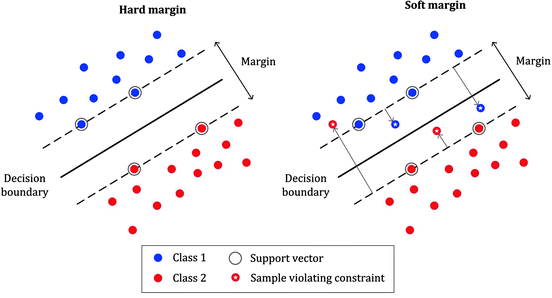



In both the soft margin and hard margin case we maximize the margin between support vectors. In soft margin case, we let our model give some relaxation to few points, if we consider these points our margin might reduce significantly and our decision boundary will be poorer, so instead of considering them as support vectors we consider them as error points and give certain penalty for them which is proportional to the amount by which each data point is violating the hard constraint.

### Import libraries required for this assignment

In [4]:
#Importing libraries
import numpy as np
import random
import matplotlib.pyplot as plt

from cvxopt import matrix, solvers
import copy

# Kernel SVM and Kernel Ridge Regression
from sklearn.datasets import make_circles
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge

We generate synthetic data to show the difference between soft and hard margin SVM. Our data will be kept linearly separable for showing the best effect.

In [5]:
def gen_data(num_points=500):

  # Function to generate a linearly separable dataset.
  # Generating the label = +1 data
  # Our data will be 2-dimensional having a x and y coordinates
  x_l = np.random.uniform(-10, 10, num_points)
  y_l = 10*x_l + 3 + np.random.uniform(20, 30, num_points)
  xl = list(x_l)
  yl = list(y_l)

  data = []
  for i in range(num_points):
    data.append([[1, xl[i], yl[i]], 1])

  # Generating label = -1 dataset
  x_r = np.random.uniform(-10, 10, num_points)
  y_r = 10*x_r + 3 - np.random.uniform(20, 30, num_points)
  xr = list(x_r)
  yr = list(y_r)

  for i in range(200):
    data.append([[1, xr[i], yr[i]], -1])

  random.shuffle(data)
  return data

Once the data is generated, we plot the data to show that it is linearly separable.

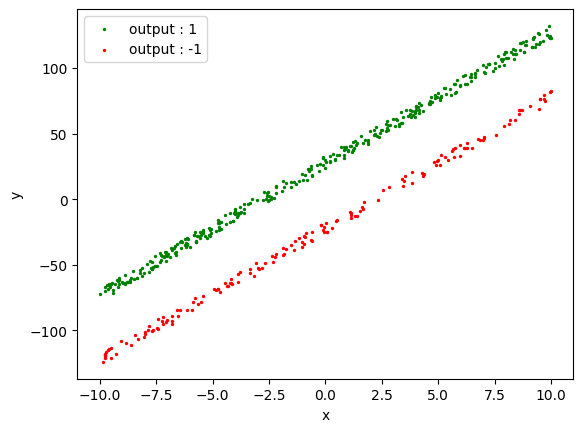

In [10]:
# Generating linearly separable data
data = gen_data()

# using 75% of the data for training
# YOUR CODE HERE
cut_point = int(len(data) * 0.75)
train_data = data[:cut_point]

# using remaining 25% of the data for testing
test_data = data[cut_point:]


# Plotting in green and red.
# Label 1 will be plotted in green and -1 in red.
# YOUR CODE HERE
x_green = []
y_green =[]

x_red = []
y_red = []

for i in range(len(train_data)):
  if train_data[i][1] == 1:
    x_green.append(train_data[i][0][1])
    y_green.append(train_data[i][0][2])
  elif train_data[i][1] == -1:
    x_red.append(train_data[i][0][1])
    y_red.append(train_data[i][0][2])
plt.scatter(x_green, y_green, color='green', s=2,label="output : 1")
plt.scatter(x_red, y_red, color='red', s=2,label="output : -1")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


Linearly separable data generated can be visualized from the above plot.

### Implementing hard-margin SVM algorithm on the linearly separable data generated above

Please go through the reference for quadatic equation and how to solve it.
 [link for quadatic equation and their solution](https://xavierbourretsicotte.github.io/SVM_implementation.html)

In [11]:
# Solve the dual formulation for SVMs
def svm(train_data):
  # Length of the training data
  N = len(train_data)

  # Multiplying step
  # Xi * Xj  * Yi * Yj
  P = []
  for i in range(N):
    for j in range(N):
      P.append(train_data[j][1]*train_data[i][1]*(np.dot(train_data[j][0][1:],
                                                         train_data[i][0][1:])))

  # Forming a matrix of N x N size.
  # N is the length of data
  P = matrix(P,(N,N))

  # Q required for QP solver
  q = np.ones((N,))*-1
  q = matrix(q)

  A = np.zeros((N,))

  for i in range(N):
    A[i]=(train_data[i][1])

  A = matrix(A,(1,N))


  b = [0.0]
  b = matrix(b)

  G = np.identity(N)*-1
  G = matrix(G)


  h = np.zeros((N,))
  h = matrix(h)

  # Optimizing and finding the alpha i's.
  alpha = solvers.qp(P, q, G, h, A, b)

  a = []
  for i in range(N):
    a.append(alpha['x'][i])

  weights = [0,0]

  # Calculating the weights of the trained SVM
  # YOUR CODE HERE
  for i in range(N):
    weights[0] += alpha['x'][i]*train_data[i][1]*train_data[i][0][1]
    weights[1] += alpha['x'][i]*train_data[i][1]*train_data[i][0][2]


  # Calculating the bias of the trained model
 # YOUR CODE HERE
  bias = (1/train_data[a.index(max(a))][1]) - (weights[0]*train_data[a.index(max(a))][0][1] + weights[1]*train_data[a.index(max(a))][0][2])

  return weights, bias


weights_svm, bias = svm(train_data)

     pcost       dcost       gap    pres   dres
 0: -6.9251e+00 -8.5156e+00  7e+02  3e+01  1e+00
 1: -3.8822e-01 -4.1599e-01  2e+01  6e-01  3e-02
 2:  5.5492e-03 -3.7982e-01  6e-01  7e-03  3e-04
 3: -8.4848e-02 -1.6304e-01  8e-02  2e-17  4e-14
 4: -1.0209e-01 -1.2739e-01  3e-02  8e-18  4e-14
 5: -1.0418e-01 -1.2876e-01  2e-02  3e-17  5e-14
 6: -1.2056e-01 -1.2799e-01  7e-03  6e-17  1e-13
 7: -1.2393e-01 -1.2563e-01  2e-03  2e-17  1e-13
 8: -1.2503e-01 -1.2532e-01  3e-04  6e-17  2e-13
 9: -1.2529e-01 -1.2529e-01  3e-06  1e-17  2e-13
10: -1.2529e-01 -1.2529e-01  3e-08  7e-17  2e-13
Optimal solution found.


### Visualizing the decision boundary generated by hard-margin SVM

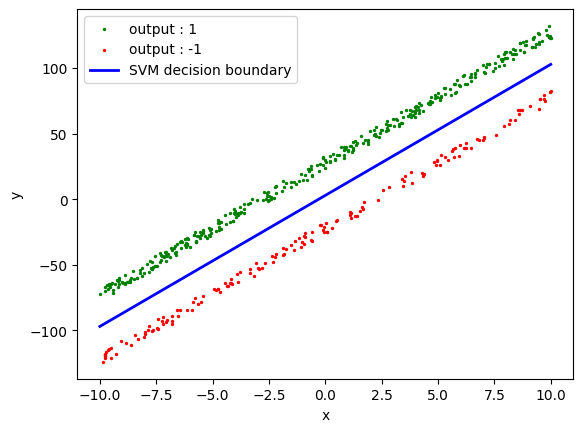

In [12]:
# plot the decision boundary with training data points first.
# The support vectors are the points which are the closest to the boundary.

plt.scatter(x_green, y_green, color='green', s=2,label="output : 1")
plt.scatter(x_red, y_red, color='red', s=2,label="output : -1")

x_boundary_svm = np.linspace(-10,10,2)
y_boundary_svm = (-weights_svm[0]/weights_svm[1])*x_boundary_svm +(-bias/weights_svm[1])

plt.plot(x_boundary_svm, y_boundary_svm, color='blue', linewidth = 2,
         marker='o', markerfacecolor='blue', markersize=0,
         label="SVM decision boundary")

# plot the decision boundary and lebel it
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

The above plot shows the decision boundary generated by hard-margin SVM and the training data points.

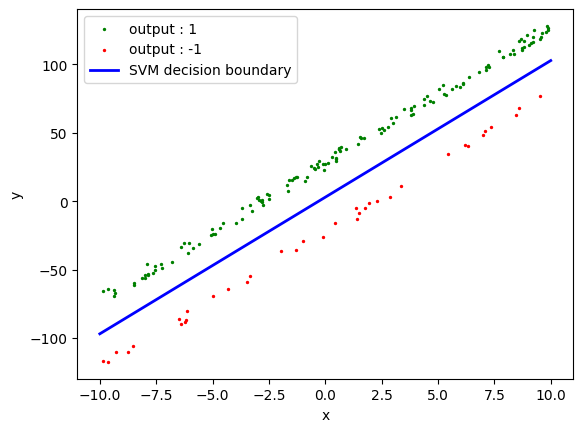

In [13]:
# Plotting the decision boundary with testing data points

x_green_test = []
y_green_test = []
x_red_test = []
y_red_test = []
for i in range(len(test_data)):
    if(test_data[i][1]==1):
        x_green_test.append(test_data[i][0][1])
        y_green_test.append(test_data[i][0][2])
    elif (test_data[i][1]==-1):
        x_red_test.append(test_data[i][0][1])
        y_red_test.append(test_data[i][0][2])

plt.scatter(x_green_test, y_green_test, color='green', s=2,label="output : 1")
plt.scatter(x_red_test, y_red_test, color='red', s=2,label="output : -1")
x_boundary_svm = np.linspace(-10,10,2)
y_boundary_svm = (-weights_svm[0]/weights_svm[1])*x_boundary_svm +(-bias/weights_svm[1])

plt.plot(x_boundary_svm, y_boundary_svm, color='blue', linewidth = 2,
         marker='o', markerfacecolor='blue', markersize=0,
         label="SVM decision boundary")

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

The above plot shows the decision boundary generated by hard-margin SVM and the testing data points.

As we can see the linearly separable data is nicely separated using a line. But what happens if there is some noise in the training data. How will we have some margin such that algorithm can be robust and not overfit on train data. Most importantly, how do we make this algorithm work on non-linearly separable data.

### Implementing Soft Margin SVM on noisy data.

Creating noisy data first to make sure they are not fully linearly separable. The noisy items will cause the data to be slightly non-linear.

In [14]:
# Function to add gaussian noise with mean=0 and standard deviation=sd in the data.
def add_noise(data, sd):
  ans = copy.deepcopy(data)
  noise_x = np.random.normal(0, sd, (len(data),))
  noise_y = np.random.normal(0, sd*10, (len(data),))

  for i in range(len(data)):
    ans[i][0][1] += noise_x[i]
    ans[i][0][2] += noise_y[i]

  return list(ans)


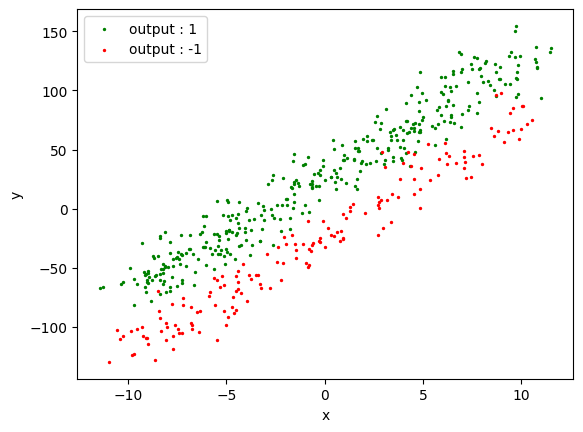

In [16]:
# Using the previously generated data to make it noisy.
noisy_data = add_noise(data, 1)

# using 75% of the data for training
cut_point = int(len(noisy_data) * 0.75)
train_data = noisy_data[:cut_point]

# using remaining 25% of the data for testing
test_data = noisy_data[cut_point:]


# Plotting in green and red.
# Label 1 will be plotted in green and -1 in red.
x_green = []
y_green = []

x_red = []
y_red = []


# YOUR CODE HERE
for i in range(len(train_data)):

    if(train_data[i][1]==1):
        x_green.append(train_data[i][0][1])
        y_green.append(train_data[i][0][2])

    elif (train_data[i][1]==-1):
        x_red.append(train_data[i][0][1])
        y_red.append(train_data[i][0][2])

# plot the data and lebel it.
# YOUR CODE HERE
plt.scatter(x_green, y_green, color='green', s=2,label="output : 1")
plt.scatter(x_red, y_red, color='red', s=2,label="output : -1")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

As you can see, the data is no longer linearly separable! Therefore, we need some chnages in the SVM formulation. Let us first train a hard margin SVM on this data.

In [17]:
# Solve the dual formulation for SVMs

def svm(train_data):
  # Length of the training data
  N = len(train_data)

  # Multiplying step
  # Xi * Xj  * Yi * Yj
  P = []
  for i in range(N):
    for j in range(N):
      P.append(train_data[j][1]*train_data[i][1]*(np.dot(train_data[j][0][1:],
                                                         train_data[i][0][1:])))

  # Forming a matrix of N x N size.
  # N is the length of data
  P = matrix(P,(N,N))

  # Q required for QP solver
  q = np.ones((N,))*-1
  q = matrix(q)

  A = np.zeros((N,))

  for i in range(N):
    A[i]=(train_data[i][1])

  A = matrix(A,(1,N))


  b = [0.0]
  b = matrix(b)

  G = np.identity(N)*-1
  G = matrix(G)


  h = np.zeros((N,))
  h = matrix(h)

  # Optimizing and finding the alpha i's.
  alpha = solvers.qp(P, q, G, h, A, b)

  a = []
  for i in range(N):
    a.append(alpha['x'][i])

  weights = [0,0]

  # Calculate the weights of the trained SVM
  for i in range(N):
    weights[0] += alpha['x'][i]*train_data[i][1]*train_data[i][0][1]
    weights[1] += alpha['x'][i]*train_data[i][1]*train_data[i][0][2]

  # Calculate the bias of the trained model
  # YOUR CODE HERE
  bias = (1/train_data[a.index(max(a))][1]) - (weights[0]*train_data[a.index(max(a))][0][1] + weights[1]*train_data[a.index(max(a))][0][2])

  return weights, bias


weights_svm, bias = svm(train_data)

     pcost       dcost       gap    pres   dres
 0: -1.2576e+02 -3.2855e+02  3e+03  5e+01  3e+00
 1: -2.5214e+02 -5.3184e+02  2e+03  4e+01  2e+00
 2: -6.3179e+02 -1.3103e+03  2e+03  4e+01  2e+00
 3: -2.7712e+03 -4.4918e+03  2e+03  3e+01  2e+00
 4: -9.3450e+03 -1.0693e+04  1e+03  2e+01  1e+00
 5: -4.6149e+04 -4.9656e+04  4e+03  2e+01  1e+00
 6: -1.2028e+05 -1.2839e+05  8e+03  2e+01  1e+00
 7: -1.9366e+06 -1.9427e+06  6e+03  2e+01  1e+00
 8: -3.8877e+08 -3.8924e+08  5e+05  2e+01  1e+00
 9: -4.0803e+08 -4.0851e+08  5e+05  2e+01  1e+00
10: -4.6270e+08 -4.6322e+08  5e+05  2e+01  1e+00
11: -5.8745e+08 -5.8803e+08  6e+05  2e+01  1e+00
Terminated (singular KKT matrix).


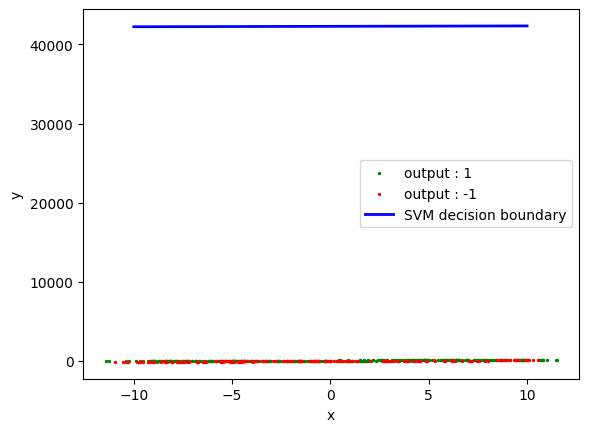

In [18]:
# plot the decision boundary with training data points first.
# The support vectors are the points which are the closest to the boundary.

plt.scatter(x_green, y_green, color='green', s=2,label="output : 1")
plt.scatter(x_red, y_red, color='red', s=2,label="output : -1")

x_boundary_svm = np.linspace(-10,10,2)
y_boundary_svm = (-weights_svm[0]/weights_svm[1])*x_boundary_svm +(-bias/weights_svm[1])

plt.plot(x_boundary_svm, y_boundary_svm, color='blue', linewidth = 2,
         marker='o', markerfacecolor='blue', markersize=0,
         label="SVM decision boundary")

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

As we can see, the decision boundary is completely destroyed in this case! This is because the data is not linearly separable!! Thus the SVM can't find a decision boundary that can separate the data. Hence we reformulate the problem and add a paramter ``c``.
This parameter allows for some additional tolerence into the formulation. Instead of finding the decision boundary that separates the classes maximally, we allow samples at  distance ``c`` from the maximal boundary to be misclassified. Overall, this increases the robustness of the algorithm as noise can be then accomodated into the picture. Below, we code a SVM with a soft margin!

In [19]:
def svm_soft(train_data, c):

  N = len(train_data)
  P = []

  for i in range(N):
    for j in range(N):
      P.append(train_data[j][1]*train_data[i][1]*(np.dot(train_data[j][0][1:],
                                                         train_data[i][0][1:])))

  P = matrix(P,(N,N))

  q = np.ones((N,))*-1
  q = matrix(q)

  A = np.zeros((N,))

  for i in range(N):
    A[i]=(train_data[i][1])

  A = matrix(A,(1,N))


  b = [0.0]
  b = matrix(b)



  G = matrix(np.vstack((np.eye(N)*-1,np.eye(N))))
  h = matrix(np.hstack((np.zeros(N), np.ones(N) * c)))

  alpha = solvers.qp(P, q, G, h, A, b)

  a = []
  for i in range(N):
    a.append(alpha['x'][i])

  weights = [0,0]

  # Calculate the weights, bias of the trained model
  # YOUR CODE HERE
  for i in range(N):
    weights[0] += alpha['x'][i]*train_data[i][1]*train_data[i][0][1]
    weights[1] += alpha['x'][i]*train_data[i][1]*train_data[i][0][2]

  bias = (1/train_data[a.index(max(a))][1]) - (weights[0]*train_data[a.index(max(a))][0][1] + weights[1]*train_data[a.index(max(a))][0][2])


  return weights, bias

Now let us train the soft margin SVM with different values of ``c`` to understand how it changes. In this notebook, we have used only one value of c = 5, please continue to change this and check its effect.

     pcost       dcost       gap    pres   dres
 0: -7.5469e+01 -2.0068e+02  4e+03  1e+01  2e-11
 1: -2.2919e+01 -1.7146e+02  4e+02  1e+00  1e-11
 2: -1.4192e+01 -6.7914e+01  9e+01  2e-01  3e-12
 3: -1.0569e+01 -2.0091e+01  2e+01  3e-02  2e-12
 4: -9.5294e+00 -1.2091e+01  4e+00  7e-03  2e-12
 5: -9.4296e+00 -1.0132e+01  1e+00  2e-03  2e-12
 6: -9.4454e+00 -9.6255e+00  2e-01  3e-04  2e-12
 7: -9.4754e+00 -9.5069e+00  4e-02  3e-05  2e-12
 8: -9.4831e+00 -9.4870e+00  5e-03  4e-06  2e-12
 9: -9.4840e+00 -9.4845e+00  5e-04  2e-07  2e-12
10: -9.4842e+00 -9.4842e+00  5e-06  2e-09  2e-12
Optimal solution found.


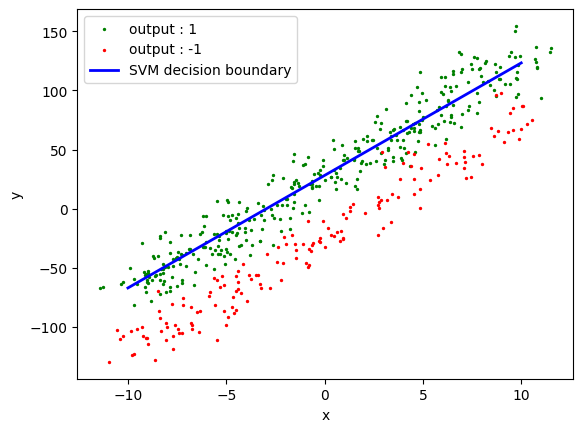

In [20]:
# plot the decision boundary with training data points first.
# The support vectors are the points which are the closest to the boundary.

weights_ssvm, bias_s = svm_soft(train_data, 0.2)

plt.scatter(x_green, y_green, color='green', s=2,label="output : 1")
plt.scatter(x_red, y_red, color='red', s=2,label="output : -1")

x_boundary_svm = np.linspace(-10,10,2)
y_boundary_svm = (-weights_ssvm[0]/weights_ssvm[1])*x_boundary_svm +(-bias_s/weights_ssvm[1])

plt.plot(x_boundary_svm, y_boundary_svm, color='blue', linewidth = 2,
         marker='o', markerfacecolor='blue', markersize=0,
         label="SVM decision boundary")

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# plot the decision boundary and lebel it
# YOUR CODE HERE

### Ungraded Excercise
Please change the value of ``c`` to understand its effect. You may also change the noise level that is added to the training data. And check how that affects the performance of hard margin and soft margin SVM.


### Kernel SVMs

Now let us move on to kernel SVMs which uses a kernel trick to introduce non linearity in the whole setting. The idea here is that, the data must be linearly separable at a higher dimensions. Kernel SVMs can potentially be extremely useful for non linear data, similar and more powerful than the one we handled using soft-margin SVM. While soft margin SVM simply adds some tolerence in the decision boundary to treat some samples as noise and thus allows misclassification, kernel SVMs can create decision boundaries which can be any curve (not restricted to lines!!)

We check out on a circular dataset. A circular data is specifically designed to test non linear classification. As plotted below, a circular data can NEVER be classfied using a straight line. we will need a non linear classification method such as a kernel SVM for this.

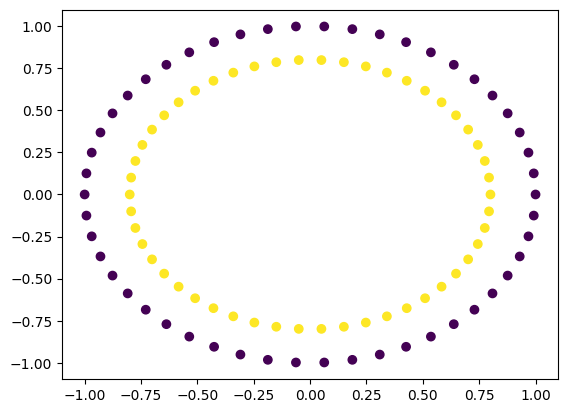

In [21]:
# Create circles data
X, y = make_circles()

# Plot the circular data
plt.scatter(X[:, 0], X[:, 1], c=y)




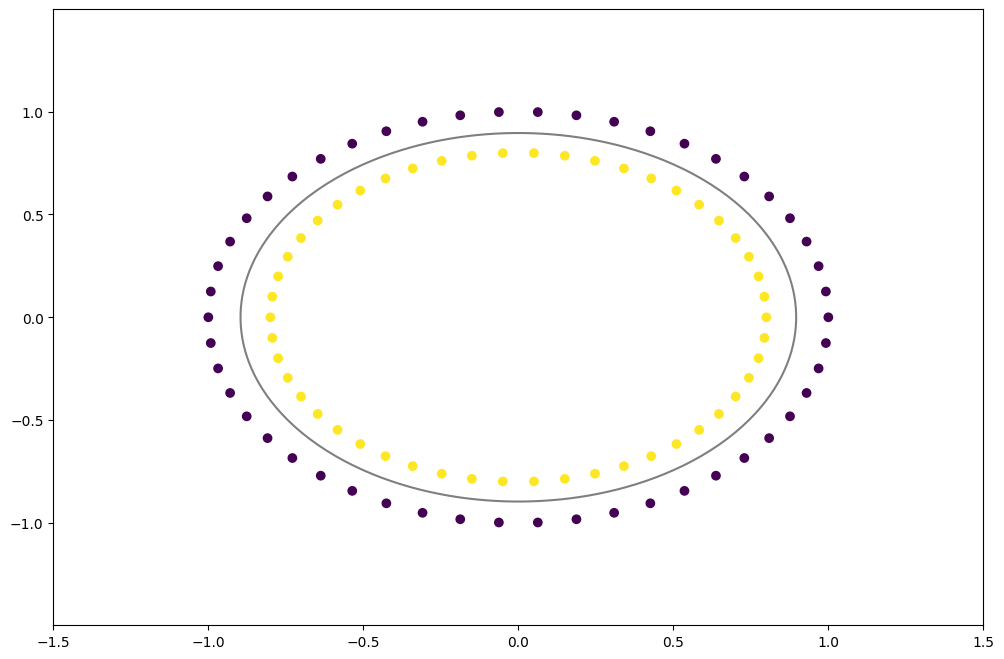

In [22]:
# Define a train a kernel SVM!
model = SVC(kernel="rbf").fit(X, y)

# Plot the hyperplane
plt.figure(figsize=(12, 8))

ax = plt.gca()

# create grid to evaluate model
xx = np.linspace(np.min(X[:, 0]) - 0.5, np.max(X[:, 0]) + 0.5, 100)
yy = np.linspace(np.min(X[:, 1]) - 0.5, np.max(X[:, 1]) + 0.5, 100)

YY, XX = np.meshgrid(yy, xx)

xy = np.vstack([XX.ravel(), YY.ravel()]).T

# Decide the value for each grid
Z = model.decision_function(xy).reshape(XX.shape)

# Plot the data
plt.scatter(X[:, 0], X[:, 1], c=y)

# plot decision boundary (take only z = 0)
ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5,
           linestyles=['-'])

### Kernel SVM with Soft Margin

As shown in the linear SVM, even Kernel SVMs can have a soft margin. This can be used for the same purpose as done in the linear case: to add some regularization and tolerence. We show an example below.

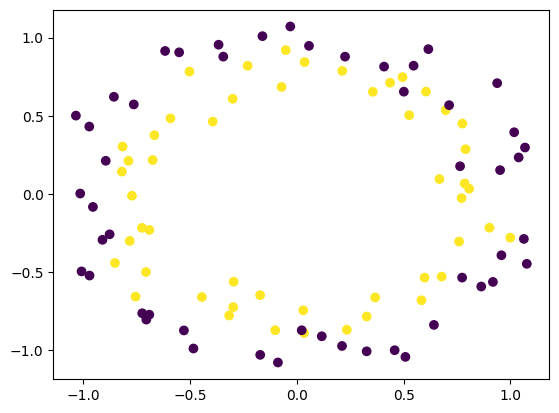

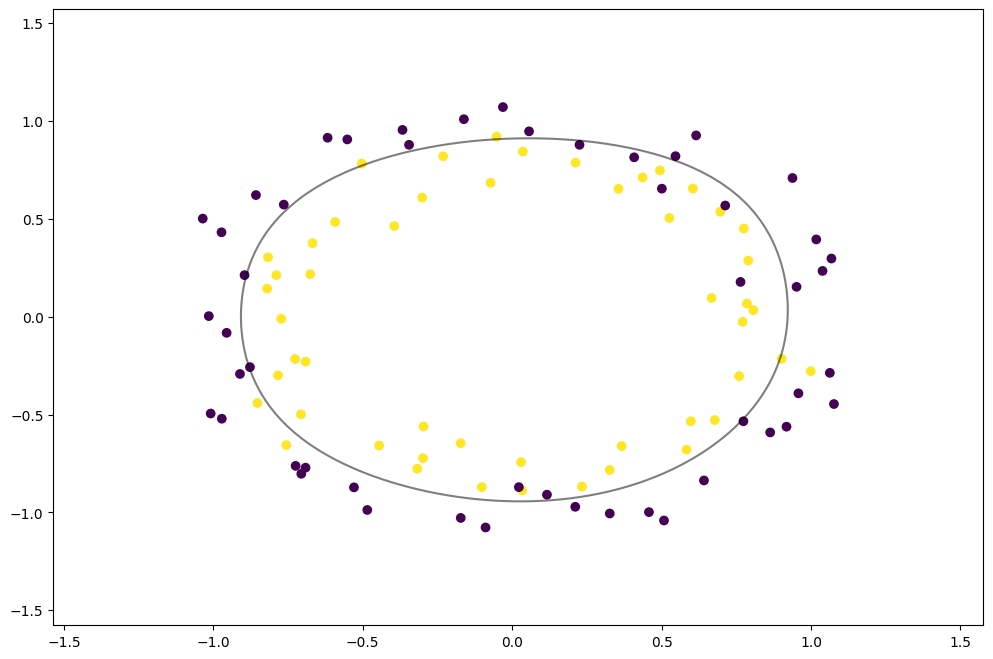

In [23]:
# Adding some noise to the data
# Change the noise levels to understand the difference
X, y = make_circles(noise=0.1)

# Plot the circular data
plt.scatter(X[:, 0], X[:, 1], c=y)

# Define a train a kernel SVM!
# Adding C=5
# Change C to understand the difference
model = SVC(kernel="rbf", C=5).fit(X, y)

# Plot the hyperplane
plt.figure(figsize=(12, 8))

ax = plt.gca()

# create grid to evaluate model
xx = np.linspace(np.min(X[:, 0]) - 0.5, np.max(X[:, 0]) + 0.5, 100)
yy = np.linspace(np.min(X[:, 1]) - 0.5, np.max(X[:, 1]) + 0.5, 100)

YY, XX = np.meshgrid(yy, xx)

xy = np.vstack([XX.ravel(), YY.ravel()]).T

# Decide the value for each grid
Z = model.decision_function(xy).reshape(XX.shape)

# Plot the data
plt.scatter(X[:, 0], X[:, 1], c=y)

# plot decision boundary (take only z = 0)
ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5,
           linestyles=['-'])

### Kernel Ridge Regression


Linear regression can be thought as the line fitting problem where a straight line fits to a set of points. However what if the points are arranged in a non linear curve, like a circle!? Kernel ridge regression was designed to work in this exact situation. It is used to fit non linear curves to a set of points. The idea is again the same: at some higher dimension the data can be fitted with a linear curve and the kernel trick allows us to project the data into a higher dimension.

We first create a circular data for training the kernel ridge regression algorithm

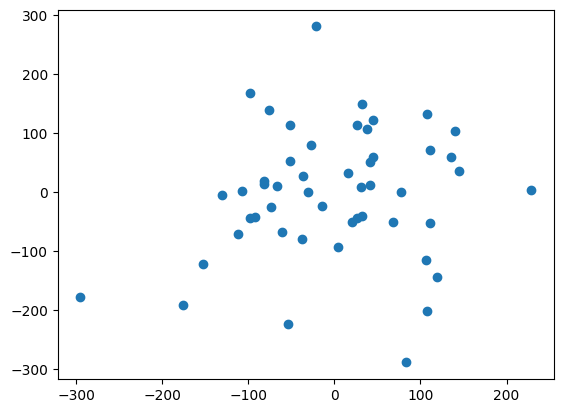

In [24]:
# Create circles data
X, y = make_circles(noise=100)

# Create data for only one class
new_X = []

for i in range(len(y)):
  if y[i] == 0:
    new_X.append(list(X[i]))

new_X = np.array(new_X)

# Plot the circular data
plt.scatter(new_X[:, 0], new_X[:, 1])

Now let us code the KRR algorithm

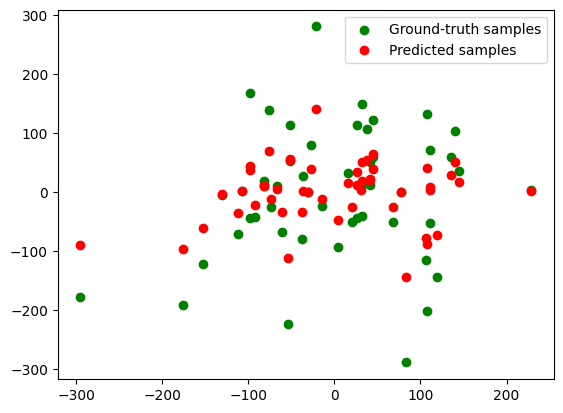

In [25]:
krr = KernelRidge(alpha=1.0, kernel='rbf', degree=2)
krr.fit(new_X[:, 0].reshape(-1, 1), new_X[:, 1].reshape(-1, 1))

pred_x = krr.predict(new_X[:, 0].reshape(-1, 1))
pred_x = pred_x.reshape(-1)

# Plot the points predicted
# Plot the original points too

plt.scatter(new_X[:, 0], new_X[:, 1], color='green', label="Ground-truth samples")
plt.scatter(new_X[:, 0], pred_x, color='red', label="Predicted samples")

plt.legend()


### Please answer the questions below to complete the experiment:




In [26]:
# @title In SVM, the dimension of the hyperplane depends upon which one? { run: "auto", form-width: "500px", display-mode: "form" }
Answer = "Number of features in a sample" #@param ["","Number of features in a sample", "Number of support vectors", "Number of samples"]

In [27]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Was Tough, but I did it" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [28]:
#@title If it was too easy, what more would you have liked to be added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "NA" #@param {type:"string"}


In [29]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["","Yes", "No"]


In [30]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [31]:
#@title Mentor Support: { run: "auto", vertical-output: true, display-mode: "form" }
Mentor_support = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [32]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id = return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 1210
Date of submission:  23 Aug 2025
Time of submission:  00:42:00
View your submissions: https://learn-iitm.talentsprint.com/notebook_submissions
